### Overview

Twitter users generate millions of tweets everyday, and much of this is aimed at a particular product or brand. Companies need to find quick and effective ways to sort through the millions of tweets and identify those that indicate unhappy consumers so that they can quickly respond before the negative experience is amplified across media and the company risks losing customers. It is also important that companies are able to correctly identify positive brand sentiment so that those tweets can be amplified across social media.

### Aim:
To classify a tweet as having positive or negative sentiment.

A set of actual tweets will be vectorized with the help of Natural Language Processing. Then modeling techniques will be used to classify them as either positive or negative.

### Data:
The dataset used in this project can be found [here](https://data.world/crowdflower/brands-and-product-emotions) In this dataset, contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion.

### EDA

First, data is analyzed to ascertain cleaning requirements and to visualize the target distribution.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%load_ext autoreload
%autoreload 2

reading the csv file using pandas

In [2]:
df = pd.read_csv('../../data/judge-1377884607_tweet_product_company.csv',
                 encoding='unicode_escape',
                 header=0,
                 names=['tweet_text', 'brand', 'emotion'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text    9092 non-null object
brand         3291 non-null object
emotion       9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


1 tweet_text has a NaN value and majority of brand entries are missing...

In [4]:
df = df.dropna(subset=['tweet_text'])

In [5]:
print(df.shape)
df.head(3)

(9092, 3)


,tweet_text,brand,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


Let's Explore the data and identify the unique entries for product(`brand`) and sentiments(`emotion`).

In [6]:
df.brand.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [7]:
df.emotion.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [8]:
apple_list = ['iPhone', 'iPad or iPhone App','iPad','Apple','Other Apple product or service']
google_list = ['Google', 'Android', 'Android App', 'Other Google product or service']

def brand_name(row):
    if row in apple_list:
        return 'Apple'
    elif row in google_list:
        return 'Google'
    else:
        return np.nan

Mapping apple products to Apple and android/google products to Google

In [9]:
df.loc[:, 'brand'] = df.brand.map(brand_name)

In [10]:
df.brand.value_counts()

Apple     2409
Google     882
Name: brand, dtype: int64

In [11]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [12]:
def emotion_name(row):
    if row == 'Positive emotion':
        return 'Positive'
    elif row == 'Negative emotion':
        return 'Negative'
    else:
        return 'Neutral_or_unknown'

In [13]:
df.emotion = df.emotion.map(emotion_name)

In [14]:
df.emotion.value_counts(sort=False)

Neutral_or_unknown    5544
Positive              2978
Negative               570
Name: emotion, dtype: int64

our data has a large class imbalance both in the target variable and in the product the tweet is directed towards. We also have a large number of retweets, which are essentially duplicates. For our purposes, we are going to drop the retweets.

Let's visualize how the target is distributed with respect to the brands in our dataset

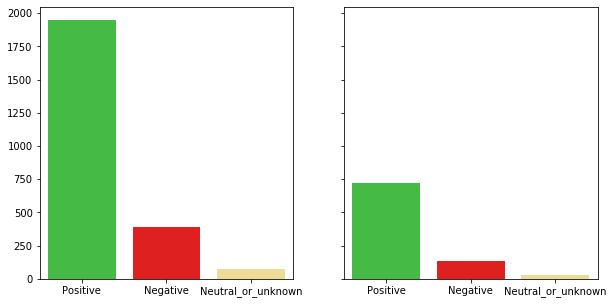

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)
for idx, brand in enumerate(['Apple', 'Google']):
    plot_data = df[df['brand'] == brand].emotion.value_counts()
    sns.barplot(x=plot_data.index, y=plot_data.values, ax=ax[idx], palette=['limegreen', 'red', '#FDE587'])
plt.show();

visualizing data for missing brand information

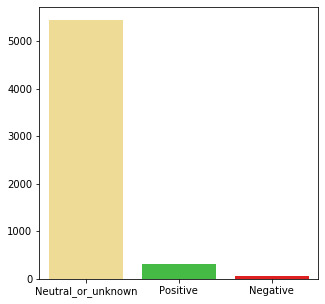

In [16]:
plt.figure(figsize=(5,5))
plot_data = df[df['brand'].isna()].emotion.value_counts()
sns.barplot(x=plot_data.index, y=plot_data.values, palette=['#FDE587', 'limegreen', 'red']); 

In [17]:
df.head(10)

,tweet_text,brand,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,Neutral_or_unknown
7,"#SXSW is just starting, #CTIA is around the co...",Google,Positive
8,Beautifully smart and simple idea RT @madebyma...,Apple,Positive
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
10,Excited to meet the @samsungmobileus at #sxsw ...,Google,Positive


In [18]:
pd.set_option('max_colwidth', 400)

In [19]:
df[(df.brand.isna()) & (df.emotion.isin(['Positive', 'Negative']))].head()

,tweet_text,brand,emotion
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link},NaN,Positive
64,Again? RT @mention Line at the Apple store is insane.. #sxsw,NaN,Negative
68,"Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw",NaN,Negative
103,Know that &quot;dataviz&quot; translates to &quot;satanic&quot; on an iPhone. I'm just sayin'. #sxsw,NaN,Negative
112,Spark for #android is up for a #teamandroid award at #SXSW read about it here: {link},NaN,Positive


357 entries that have missing brand values exhibit either a positive or negative emotion. From the tweet_text we can ascertain the brand being discussed about. If the text has either Apple, iPhone or iPad we'll assume the brand being discussed is Apple and if the text has either android or Google we can assume the brand to be Google

In [20]:
# missing_brand = df[(df.brand.isna()) & (df.emotion.isin(['Positive', 'Negative']))]

# def brand_name_for_missing_brands(row):
#     from re import search
#     if search(r'Apple|iPad|iPhone', row['tweet_text']):
#         return 'Apple'
#     elif search(r'android|Google', row['tweet_text']):
#         return 'Google'
#     else:
#         return np.nan

# missing_brand['brand'] = missing_brand.apply(brand_name_for_missing_brands, axis=1)

# missing_brand

# df1 = df[~(df.brand.isna()) & (df.emotion.isin(['Positive', 'Negative']))]

# df = pd.concat([df1, missing_brand], axis=0)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text    9092 non-null object
brand         3291 non-null object
emotion       9092 non-null object
dtypes: object(3)
memory usage: 284.1+ KB


Retweets in the dataset are tagged with characters 'RT' in the tweet_text. Let's remove tweet containing 'RT' pattern using `re`

In [22]:
from re import search
def not_a_retweet(row):
    if not search(r'RT', row):
        return True
    else:
        return False       

In [23]:
df = df[df.tweet_text.map(not_a_retweet)].loc[:,['tweet_text', 'emotion', 'brand']]

In [24]:
df.shape

(6415, 3)

In [25]:
df.head()

,tweet_text,emotion,brand
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative,Apple
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive,Apple
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive,Apple
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative,Apple
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive,Google


In [26]:
corpus = df.loc[:, ['tweet_text', 'emotion']] 

In [27]:
corpus.head()

,tweet_text,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive


### Preprocessing

In [28]:
X = corpus['tweet_text']
y= corpus['emotion']
print(len(X))
print(len(y))
len(X) == len(y)

6415
6415


True

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [31]:
from nltk.corpus import stopwords, wordnet
sw = stopwords.words('english')
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [32]:
from nltk.tokenize import word_tokenize, regexp_tokenize, RegexpTokenizer

In [33]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [34]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [43]:
# import nltk
# nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lulualakdawala/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [35]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in stop_words]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [36]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [37]:
token_docs[0]

'ipad acquire thanks mention perserverance vote husband year check sxsw'

In [38]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=1)

In [53]:
X_t

['google say future location location location link sxsw cnn',
 'ipad come sxsw guess apple pretty desperate give attention',
 'listen mention talk ipad design sxsw',
 'case wanna stalk google austinjs rocksauce shang accomplish thing sxsw',
 'hey mention get another gem gt free mention sxsw link sxsw',
 'buy last ipad g mb apple pop store sxsw link',
 'google launch major new social network call quot circle quot link sxsw via mention mention cc mention mentionc',
 'check step bulletproof ux strategy sxsw link sxsw rhjr ux link',
 'quot take time others catch ipad quot mention tapworthy sxsw',
 'mom ipad design boomer sxsw link sxsw',
 'massive sxsw fail run ipad mention semi full park front justsayin link',
 'wish sxsw wish ipad say',
 'apple popup sxsw retail store austin detail belies short wk lifespan link link',
 'cashmere mashable think ipad huge step wait apple pr team parachute sxsw session',
 'sxsw smileyparty really want win sn ipad',
 'million mobile user google map mobile s

In [48]:
y_t[5]

KeyError: 5

In [52]:
y_t.iloc[0]

'Neutral_or_unknown'